# Convolution of incident energy spectrum

*Erik Hogenbirk, September 2016, ehogenbi@nikhef.nl*

Source code at https://github.com/XENON1T/PTB

As shown by Jacques in his Jacques' note, (https://xecluster.lngs.infn.it/dokuwiki/lib/exe/fetch.php?media=xenon:xenon1t:jacques:mc_matching.html) we can get an incident spectrum of neutrons for the NE213, based on a few assumptions and some data from the CRC manual. In this notebook, I take this spectrum and apply the response fuction of the NE213, then scale it and compare it to the data. Both for background subtracted and background rejected data, the agreement is excellent, so that we should reconsider if we should do deconvolution at all.

In [1]:
from IPython.core.display import HTML
HTML("<style>.container { wdith:90% !important;}</style>")
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code"></form>''')

## Imports and reading data

In [2]:
# Import everything, including things like PTB data, the response function and necessary functions
%run '07b_deconvolution_definitions.ipynb'
import time
print('Computation of previous notebooks took %d seconds' % (time.clock()))

Computation of previous notebooks took 127 seconds


In [3]:
# Read in the data
fn = './simu/NE213_E_Spectrum.root'

# Relevant imports to reading in 
import ROOT
import root_numpy as rn

# Actually read the root file
f = ROOT.TFile(fn)
treenames = rn.list_trees(fn)
assert len(treenames) == 1
tree = f.Get(treenames[0])
data = rn.tree2array(tree)

# Somehow the data is stored in the form of an array of tuples... wtf? So here's a hack to get it out!
sim_energies = np.array([d[0] for d in data])
print('Read a total of %d events from file %s.' % (len(sim_energies), fn))

Read a total of 104603 events from file ./simu/NE213_E_Spectrum.root.


### The energy distribution

In [7]:
# Compute initial energy distribution
# Code stolen fromJacques to get the initial energy dist.
from tqdm import tqdm
emission_prob = []
energies = []
for i in tqdm(range (0, 1000000)):
    x=np.random.ranf()
    x=2*x-1
    weight=(1+0.11787*x+0.58355*np.power(x,2)+-0.11353*np.power(x,3)+0.0422*np.power(x,4)+0.16359*np.power(x,5))
    energy=(2.46073+(0.24848*x+0.01282*np.power(x,2)+0.00031*np.power(x,3)))
    energies.append(energy)
    emission_prob.append(weight)

In [8]:
# Here is a custom histogram fuction, which is necessary because of the uneven bin spacing in the convolution matrix.
def make_hist(bin_edges, vals, norm_bin = True):
    '''Build a histogram of vals with custom bin edges.
    vals must be cool with indexing such as vals[vals > 1] (try np.array)
    Normalizes by bin width as well.    
    Includes bin value to the left (i.e. half-open intervals)
    Recommended to check :)
    '''
    hist = []
    for i in range(len(bin_edges)-1):
        bin_left = bin_edges[i]
        bin_right = bin_edges[i+1]
        bin_width = bin_right - bin_left
        n_entries = len(vals[(vals >= bin_left) & (vals < bin_right)])
        if norm_bin:
            hist.append(n_entries / bin_width)
        else:
            hist.append(n_entries)# / bin_width)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    return bin_centers, np.array(hist)

In [9]:
x1, sim_spec = make_hist(1000*neutron_energies, sim_energies, norm_bin = True)
# append a zero so that we follow neutron_energies
# This might giva a ~ < 15 keV offset
sim_spec = np.concatenate([sim_spec, np.array([0])])

In Fig. 1, I show the distribution that we get from simulation, along with the initial distribution of the energy of neutrons at production in the plasma. This is the starting point for this notebook. Note that the scaling here is arbitrary, the comparison is just to show that the influence of scattering in the NG is highly relevant for us.

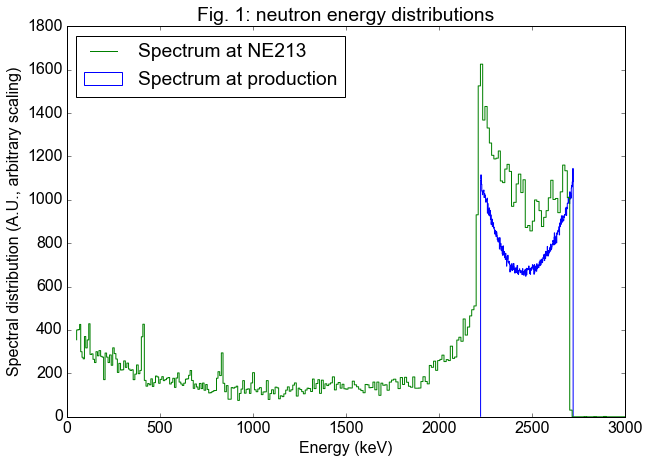

In [10]:
# Scaling factor
arbfac1 = 10
atne213, = plt.plot(neutron_energies * 1000, arbfac1*sim_spec, color='green', label='Spectrum at NE213',
                   ls='steps')
# Enable this line if you don't trust the make_hist function :)
#plt.hist(sim_energies, range=(0,3000), bins=300, histtype='step', label='Normal bins')
plt.hist(1000*np.array(energies), bins=300, histtype='step', 
         weights=0.2*np.array(emission_prob), #0.2 to sort of match the shapes of the distributions
                  label='Spectrum at production')
plt.xlim(0,3000)
plt.ylim(0,1800)
plt.xlabel('Energy (keV)')
plt.ylabel('Spectral distribution (A.U., arbitrary scaling)')
plt.title('Fig. 1: neutron energy distributions')
plt.legend(loc='upper left')
plt.show()


## Calculate convolution

First, let's get the detector response to an energy as given in Fig. 1. This is quite straightforward (and all the necessary functions are defined in previous notebooks); the result is shown in Fig. 2.

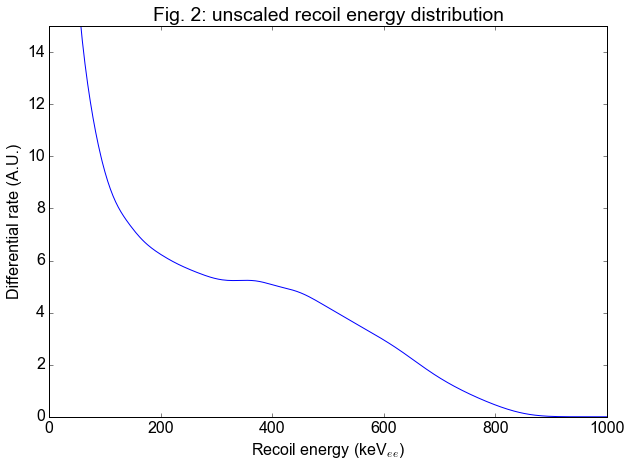

In [11]:
response_sim_spec = get_neutron_spectrum_custom_interpolated(e_scale, sim_spec)
plt.plot(e_scale, response_sim_spec)
plt.xlim(0,1000)
plt.ylim(0,15)
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Differential rate (A.U.)')
plt.title('Fig. 2: unscaled recoil energy distribution')
plt.show()

## Scale (fit) to data

We now have the recoil spectrum corresponding to the simulated neutron energy spectrum, the only thing we have to do to compare this to data is *scale* the function. Other than this, the only tricky part is the low-energy cutoff. The high-energy cutoff of the fit should be at about 900 keV$_{ee}$, as I showed in a previous note.

In [12]:
class Fit1D:
    limits = (-np.inf, np.inf)
    fit_options = dict(a = 1, errordef = 1, error_a = 1)
    m = None
    
    def __init__(self, x, y_data, y_err, y_model):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err
        self.y_model = y_model
        self.sel = np.array([True for it in y_data])
    
    def debug(self):
        print(len(self.x))
        print(len(self.y_data))
        print(len(self.y_err))
        print(len(self.y_model))        
        
    def set_limits(self, limits):
        self.limits = limits
        self.sel = (self.x >= limits[0]) & (self.x < limits[1])
        
    def chi2(self, a):
        return sum((self.y_data[self.sel] - a*self.y_model[self.sel])**2 / 
                   (self.y_err[self.sel])**2) / len(self.y_data[self.sel])
        
    def fit(self):
        self.m = Minuit(self.chi2, **self.fit_options)
        self.m.migrad()
        
    def residuals(self):
        return (self.y_data - self.m.values['a']*self.y_model) / self.y_err
    
    def plot(self):
        scale_factor = self.m.values['a']
        plt.plot(self.x, scale_factor * self.y_model)
        plt.errorbar(self.x, self.y_data, self.y_err, ls='None', marker='.', markersize=5)
        for asdf in self.limits:
            plt.axvline(asdf, ls='--', color='red')
            
    def plot_res(self, **kwargs):
        plt.plot(self.x, self.residuals(), **kwargs)
        for asdf in self.limits:
            plt.axvline(asdf, ls='--', color='red')
        plt.axhline(0, color='black')
        for i in (-1,1):
            plt.axhline(i, color='gray', ls='--')
            plt.axhline(2*i, color='black', ls=':')
            
    def opt_chi2(self):
        return self.chi2(self.m.values['a'])

### Background rejected

#### Reminder: acceptance at low energy

For the background subtracted spectrum, we're limited by the acceptance on the low energy side. At low energy, the neutron and electronic recoil bands start to overlap. I have made a crude acceptance estimate shown in Fig. 3. I choose a fit range starting at 300 keV$_{ee}$, corresponding to an acceptance of about 89%.

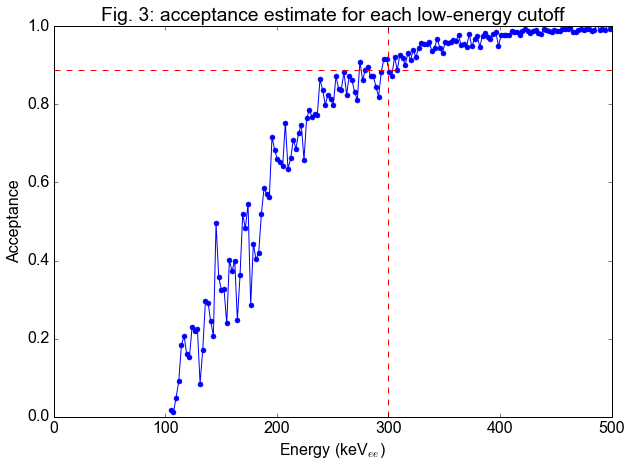

In [13]:
acc_acceptances = np.array(acc_acceptances)
plt.plot(acc_thresholds_energy, acc_acceptances, marker='.', markersize=10)
plt.axhline(np.average(acc_acceptances[(acc_thresholds_energy > 290) & (acc_thresholds_energy < 310) ]), 
            color='red', ls='--')
plt.axvline(300, color='red', ls='--')
plt.ylim(0,1)
plt.xlim(0,500)
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Acceptance')
plt.title('Fig. 3: acceptance estimate for each low-energy cutoff')
plt.show()

In [14]:
%%capture
fit_disc_sub = Fit1D(e_scale, fg_disc_sub, fg_disc_sub_err, response_sim_spec)
fit_disc_sub.set_limits((300,900))
fit_disc_sub.fit()

Fig. 4 shows the fit and the data for the best-fit scaling. The bottom panel shows the residuals in units of sigma, where by-eye I cannot see a systematic effect. 

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


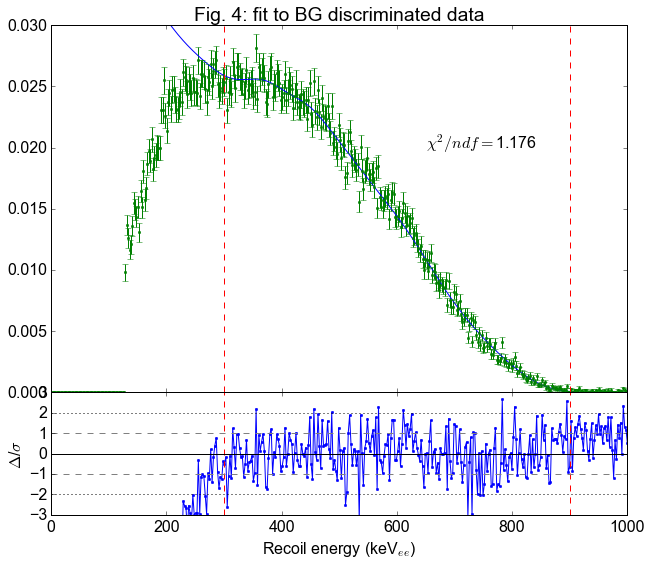

In [15]:
plt.figure(figsize=(10,8.5))
frame1=plt.gcf().add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
fit_disc_sub.plot()
plt.xlim(0,1000)
plt.ylim(0,0.03)
plt.text(650, 0.02,'$\chi^2/ndf = $%.3f' % (fit_disc_sub.opt_chi2()))

frame2=plt.gcf().add_axes((.1,.1,.8,.2))   
fit_disc_sub.plot_res(color='blue', marker='.', markersize=5)
plt.ylabel('$\Delta$/$\sigma$')
plt.xlim(0,1000)
plt.ylim(-3,3)
plt.xlabel('Recoil energy (keV$_{ee}$)')

frame1.set_title('Fig. 4: fit to BG discriminated data')
plt.show()

### BG subtracted

For the background subtracted spectrum, we can go even lower in energy. The lower threshold is eventually limited by the x-rays caused by the neutron generator (which are not in background, so we cannot subtract them). For the next plot, I take a cutoff of 150 keV$_{ee}$.

In [16]:
%%capture
fit_sub = Fit1D(e_scale, fg_sub, fg_sub_err, response_sim_spec)
fit_sub.set_limits((150,900))
fit_sub.fit()

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


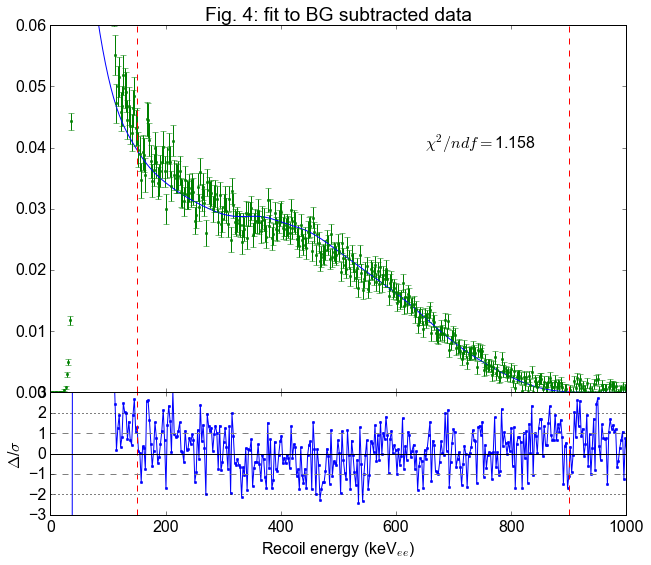

In [17]:
plt.figure(figsize=(10,8.5))
frame1=plt.gcf().add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
fit_sub.plot()
plt.xlim(0,1000)
plt.ylim(0,0.06)
plt.text(650, 0.04,'$\chi^2/ndf = $%.3f' % (fit_sub.opt_chi2()))


frame2=plt.gcf().add_axes((.1,.1,.8,.2))   
fit_sub.plot_res(color='blue', marker='.', markersize=5)
plt.ylabel('$\Delta$/$\sigma$')
plt.xlim(0,1000)
plt.ylim(-3,3)
plt.xlabel('Recoil energy (keV$_{ee}$)')

frame1.set_title('Fig. 4: fit to BG subtracted data')
plt.show()